In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

/home/mizzou/anaconda3/envs/fastai/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}

Bad key "text.kerning_factor" on line 4 in
/home/mizzou/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/home/mizzou/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the 

In [ ]:
df=pd.read_csv('traindata1.csv')

In [ ]:
df_test_ori=pd.read_csv('df_test_ori.csv')

In [ ]:
df.head()

,speed,dominant_freq,strength,auc,sum,iri_18,iri
0,67.0,6.031520,5.243716,77.880470,4.358868,47.590,48.311
1,67.0,4.857650,4.368738,77.387535,4.808348,51.017,53.297
2,66.0,5.029076,4.242908,68.315544,3.843514,55.600,60.407
3,65.0,12.823944,13.123000,222.031040,4.653536,51.541,55.120
4,65.0,4.630312,3.345422,57.393856,2.645581,66.616,164.691


In [ ]:
cat_vars = ['speed']

contin_vars = ['dominant_freq', 'strength','auc','sum','iri_18']

# contin_vars = ['dominant_freq', 'mean_freq', 'std_freq', 'max_power',
#    'mean_power', 'std_power','strength','p_auc']

n = len(df); n

406

In [ ]:
joined = df
dep = 'iri'
joined = joined[cat_vars+contin_vars+[dep]].copy()

joined_test = df_test_ori
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep]].copy()

In [ ]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()
apply_cats(joined_test, joined)

In [ ]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

In [ ]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined
samp_size = len(joined_samp); samp_size

406

In [ ]:
samp_size = n

In [ ]:
df, y, nas, mapper = proc_df(joined_samp, 'iri', do_scale=True)
yl = np.log(y)

In [ ]:
df_test, _, nas, mapper = proc_df(joined_test, 'iri', do_scale=True, mapper=mapper, na_dict=nas)

In [ ]:
#train_ratio = 0.80
train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [ ]:
train_size

365

In [ ]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [ ]:
PATH = '.../rough_app/PyEMD/results/models'
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=16,
                                       test_df=df_test)

In [ ]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [ ]:
cat_sz

[('speed', 25)]

In [ ]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [ ]:
emb_szs

[(25, 13)]

In [ ]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [ ]:
lr = 1e-4
m.lr_find()

epoch      trn_loss   val_loss                   
    0      3.750432   13.299912 



In [ ]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [ ]:
m.fit(lr, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe       
    0      0.517777   1.751982   2.910654  
    1      0.420357   0.223014   0.696094        
    2      0.313841   0.084381   0.32333         



[0.0843813794596893, 0.32333044471032046]

In [ ]:
m.fit(lr, 10, metrics=[exp_rmspe], cycle_len=2)

epoch      trn_loss   val_loss   exp_rmspe       
    0      0.034669   0.122452   0.272263  
    1      0.03193    0.044301   0.244792        
    2      0.032093   0.037369   0.196871        
    3      0.025069   0.030012   0.16956         
    4      0.024284   0.029194   0.166617        
    5      0.020157   0.029565   0.165529        
    6      0.019265   0.031934   0.160749        
    7      0.01741    0.033019   0.186783        
    8      0.020512   0.054427   0.265994        
    9      0.019725   0.031862   0.191069        
    10     0.018358   0.033285   0.194229        
    11     0.016305   0.030454   0.179515        
    12     0.016457   0.036995   0.229995        
    13     0.014943   0.032174   0.181765        
    14     0.01592    0.033605   0.175781        
    15     0.01465    0.031703   0.181382        
    16     0.013347   0.030505   0.181443        
    17     0.012193   0.031183   0.177107        
    18     0.014819   0.050074   0.222222        
    19

[0.03182205794061103, 0.17371594703160875]

In [ ]:
pwd

'/home/mizzou/fastai/old'

In [ ]:
filename='final_model1.sav'
pickle.dump(m,open(filename,'wb'))

In [ ]:
lmodel=pickle.load(open('.../fastai/old/final_model1.sav','rb'))

In [1]:
iri_val = df_test_ori['iri'].values
pred_val = []
errors = []
for cur_row,ori in zip(lmodel.data.test_ds,iri_val):
    predictions = np.exp(predict_single_record(m,cur_row))[0][0]
    errors.append(math.sqrt((ori-predictions)**2))
    pred_val.append(predictions)

print ('sum of prediction errors: ' + str(np.mean(errors)))
fig= plt.figure()
plt.plot(iri_vals,'k',label='true')
plt.plot(pred_vals,'r', label='predicted')
plt.legend(loc="upper left")
plt.show()
#fig.savefig('time.png')

fig= plt.figure()
plt.plot(errors)
plt.show()
#fig.savefig('tim3.png')


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df_test_ori = pd.read_csv('df_test_ori.csv')
df_test_ori.head(10)

,log,speed,dominant_freq,mean_freq,std_freq,max_power,mean_power,std_power,strength,auc,sum,rut,cond,iri_18,iri,p_auc
0,178.9,64.0,3.670280,9.656914,6.368188,4.691506,1.600944,0.633388,3.075992,26.305707,4.697125,0.1,8,44.095,39.249,0.178346
1,195.1,63.0,3.558968,3.192145,1.667060,4.964710,2.330130,1.140898,1.406800,17.105884,0.050277,0.1,10,42.790,39.067,0.290234
2,179.3,68.0,3.722092,6.420117,4.018693,4.252980,1.883453,0.774011,1.975764,21.128014,8.433567,0.1,8,37.906,43.783,0.201296
3,194.5,63.0,1.089862,1.125182,0.605962,5.750095,2.368251,1.338489,0.333029,6.017454,0.056850,0.1,10,30.642,31.037,0.955569
4,148.0,41.0,2.847452,7.281385,4.092920,4.945962,2.063636,0.921574,2.740882,27.375474,8.208811,0.1,9,47.270,45.907,0.180671
5,182.0,63.0,13.016299,12.220439,6.764077,7.557320,2.556943,1.299767,7.608715,62.376510,13.097585,0.1,8,34.508,37.464,0.121157
6,179.8,69.0,3.590399,6.907244,4.026776,3.844763,1.678037,0.663981,2.482747,22.494293,9.168638,0.1,8,36.099,34.163,0.170922
7,181.9,66.0,3.284562,10.183802,6.118100,7.401651,2.651264,1.327435,6.473035,54.884308,16.242243,0.1,8,35.485,38.453,0.134859
8,195.7,64.0,0.534669,1.304358,0.781793,5.100398,2.277936,1.145147,0.355254,6.268786,0.061880,0.1,9,69.657,48.087,0.813618
9,173.2,66.0,3.662532,8.081948,4.695423,5.569078,2.143309,0.904476,3.759960,34.757424,13.432748,0.1,8,47.731,49.527,0.160227


In [ ]:
def predict_single_record(m, row):
    single_record = [np.array(i)[None] for i in row]
    return predict(m.model,[single_record])

sum of prediction errors: 5.564470739067925


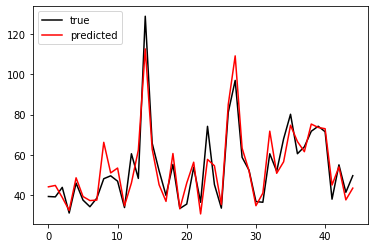

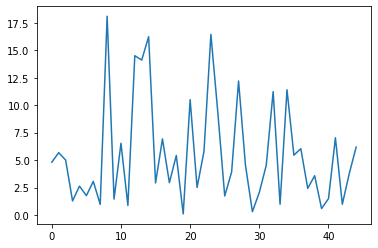

In [ ]:
iri_vals = df_test_ori['iri'].values
pred_vals = []
errors = []
for cur_row,ori in zip(m.data.test_ds,iri_vals):
    predictions = np.exp(predict_single_record(m,cur_row))[0][0]
    errors.append(math.sqrt((ori-predictions)**2))
    pred_vals.append(predictions)

print ('sum of prediction errors: ' + str(np.mean(errors)))
fig= plt.figure()
plt.plot(iri_vals,'k',label='true')
plt.plot(pred_vals,'r', label='predicted')
plt.legend(loc="upper left")
plt.show()
fig.savefig('try1.png')

fig= plt.figure()
plt.plot(errors)
plt.show()
fig.savefig('try2.png')


